# Tutorial 11
MLP on real data, using gridded monthly SST and SLP for the Tropical Pacific from ERA Interim reanalysis.  Period: Jan 1979 to Jun 2015

In [15]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

#define RMSE as a function, since we'll use this in the NN model 
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

In [3]:
#load in data
SLP = pd.read_csv('SLPdata.csv',header = None)
SST = pd.read_csv('SSTdata.csv',header = None)

In [5]:
#PCA on both datasets

data = SLP
n_modes_SLP = np.min(np.shape(SLP))
pca_SLP = PCA(n_components = n_modes_SLP)
PCs_SLP = pca_SLP.fit_transform(data)
eigvecs_SLP = pca_SLP.components_
fracVar_SLP = pca_SLP.explained_variance_ratio_

data = SST
n_modes_SST = np.min(np.shape(SST))
pca_SST = PCA(n_components = n_modes_SST)
PCs_SST = pca_SST.fit_transform(data)
eigvecs_SST = pca_SST.components_
fracVar_SST = pca_SST.explained_variance_ratio_

In [36]:
#use first 10 PCs of SLP to predict first PC of SST

x = PCs_SLP[:,:10]
y = PCs_SLP[:,0]

Ntrain = 300
x_train = x[:Ntrain]
y_train = y[:Ntrain]

x_test = x[Ntrain:]
y_test = y[Ntrain:]

#standardize
x_mean = np.mean(x_train)
x_std = np.std(x_train)

y_mean = np.mean(y_train)
y_std = np.std(y_train)

x_train = (x_train - x_mean)/x_std
y_train = (y_train - y_mean)/y_std

x_test = (x_test - x_mean)/x_std
y_test = (y_test - y_mean)/y_std

In [40]:
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

#First: MLP using 1 hidden layer with 10 neurons
#Second: MLP using 1 hidden layer with 1-10 neurons
#Third: play around with it!

max_iter = 1000 #max number of epochs to run
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.2 #fraction of training data to use as validation

y_out_all_nhn = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

##### Play around with these parameters
num_models = 10 #number of models to build for the ensemble
min_nhn = 3 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 10 #maximum number of hidden neurons to loop through
max_hidden_layers = 1 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
#####

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                activation = 'tanh')

            model.fit(x_train,y_train) #train the model

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE between cumulative curves
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 7
		 # hidden neurons = 8


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 9
		 # hidden neurons = 10
	 BEST: 1 hidden layers, 5 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 5


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 9
		 # hidden neurons = 10


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 BEST: 1 hidden layers, 9 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 5
		 # hidden neurons = 6


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 7


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 8


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10
	 BEST: 1 hidden layers, 7 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 5


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 6
		 # hidden neurons = 7


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 BEST: 1 hidden layers, 8 hidden neurons
Model Number: 4
	 # Hidden Layers = 1
		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4
		 # hidden neurons = 5


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 6
		 # hidden neurons = 7


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 8
		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10
	 BEST: 1 hidden layers, 6 hidden neurons
Model Number: 5
	 # Hidden Layers = 1
		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 BEST: 1 hidden layers, 8 hidden neurons
Model Number: 6
	 # Hidden Layers = 1
		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10
	 BEST: 1 hidden layers, 8 hidden neurons
Model Number: 7
	 # Hidden Layers = 1
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 7


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 8
		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 BEST: 1 hidden layers, 6 hidden neurons
Model Number: 8
	 # Hidden Layers = 1
		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 5


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 9
		 # hidden neurons = 10
	 BEST: 1 hidden layers, 5 hidden neurons
Model Number: 9
	 # Hidden Layers = 1
		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 5


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10
	 BEST: 1 hidden layers, 7 hidden neurons


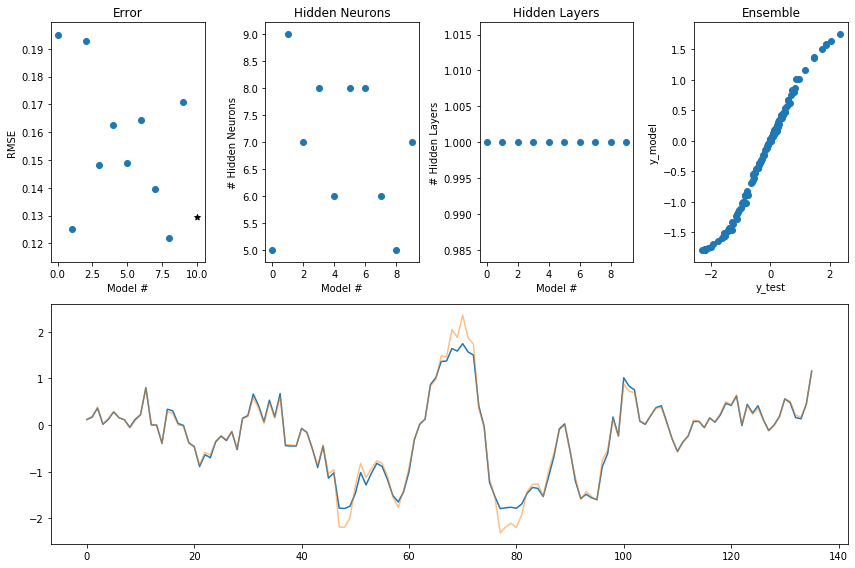

In [43]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_out_ensemble_mean)
plt.plot(y_test,alpha = 0.5)

plt.tight_layout()

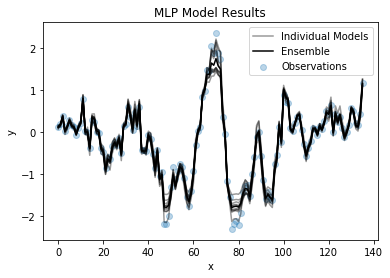

In [44]:
#visualize individual model runs

plt.scatter(range(len(y_test)),y_test,label='Observations',zorder = 0,alpha = 0.3)
plt.plot(np.transpose(y_out_ensemble[0]),color = 'k',alpha = 0.4,label='Individual Models',zorder=1)
plt.plot(np.transpose(y_out_ensemble[1:]),color = 'k',alpha = 0.4,zorder=1)
plt.plot(y_out_ensemble_mean,color = 'k',label = 'Ensemble',zorder=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('MLP Model Results')
plt.legend()

plt.show()